In [7]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

torch.cuda.set_device(0)

device = 'cuda'
batch_size = 64
num_epochs = 100

class ArgoDataset(Dataset):
    def __init__(self, file_path):
        with open(file_path, 'rb') as file:
            self.data = pickle.load(file)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        traj, label = self.data[index]
        traj = torch.tensor(traj.copy())
        label = torch.tensor(label.copy())
        return traj, label

dataset = ArgoDataset("/data/fyy/new_prediction/argoverse/intersection_data/intention_train_av_traj_and_label.pkl")
test_dataset = ArgoDataset("/data/fyy/new_prediction/argoverse/intersection_data/intention_val_av_traj_and_label.pkl")

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


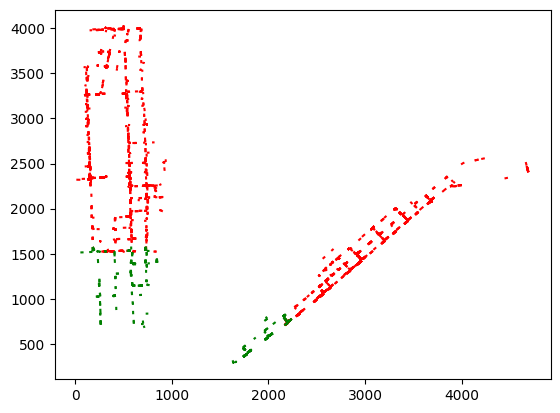

In [10]:
import matplotlib.pyplot as plt

for i in range(len(dataset)):
    traj = dataset[i][0]
    plt.plot(traj[:, 0], traj[:, 1], 'r')

for j in range(len(test_dataset)):
    traj = test_dataset[j][0]
    plt.plot(traj[:, 0], traj[:, 1], 'g')
    

In [5]:
dataset[0][1]

tensor([1, 0, 0])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        x = x.view(-1, 40)
        batch_size = x.size(0)
        sequence_length = x.size(1)
        x = x.view(batch_size, sequence_length, 1)
        
        # Apply LSTM
        h0 = torch.zeros(2, batch_size, 64).to(device)  # Initial hidden state
        c0 = torch.zeros(2, batch_size, 64).to(device)  # Initial cell state
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Reshape and pass through linear layer
        lstm_out = lstm_out[:, -1, :]  # Take the last time step output
        x = self.relu(lstm_out)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

model = Net().to(device)

# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

log_file = open("log.txt", "w")
# 训练模型
for epoch in range(num_epochs):
    for trajs, labels in train_dataloader:
        trajs = trajs.to(device).float()
        labels = labels.to(device).float()
        model.train()
        # 前向传播
        outputs = model(trajs).squeeze()

        # 计算损失
        loss = loss_fn(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        log_file.write(f"Epoch: {epoch+1}, Loss: {loss.item()}\n")

# 关闭 log.txt 文件
log_file.close()

# 保存模型权重
torch.save(model.state_dict(), "model_weights.pth")


size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
model.eval().to(device)
test_loss, correct = 0, 0
with torch.no_grad():
    for trajs, labels in test_dataloader:
        trajs, labels = trajs.to(device).float(), labels.to(device).float()
        pred = model(trajs).squeeze()
        test_loss += loss_fn(pred, labels)
        _, predicted_labels = torch.max(pred, dim=1)
        _, labels = torch.max(labels, dim=1)
        correct += (predicted_labels == labels).sum().item()

test_loss /= num_batches
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")